# Homework

Apply `BatchNorm`, `Dropout` and `Residual` on MLP networks for CIFAR-10 classification.

For BatchNorm and Dropout, design models with `BatchNorm Layer`, `Dropout Layer` and both the layers. Compare the results with a plain MLP, and with each other.

For Residual, design a simple `Redisual Block` based on a deeper MLP. Compare the results and see whether adding residual works.

Follow the pipeline in your Homework 1 to finish model designing, training and testing.

### Step 1: Load Dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

# 设置 matplotlib 显示格式
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # 设置默认图像大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# CIFAR-10 数据集的下载和加载
transform = transforms.Compose(
    [transforms.ToTensor(),  # 转换为 Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化
)

In [23]:
from torch.utils.data import Dataset, DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
class OursDatasetwithTransforms(Dataset):
    def __init__(self, data, labels, transforms):
        """
        初始化数据集
        data: 输入数据，例如一个 NumPy 数组或 PyTorch 张量
        labels: 对应的标签
        """
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        # 每个Dataset都必须写，返回数据集的大小
        return len(self.data)

    def __getitem__(self, idx):
        # 每个Dataset都必须写，获取指定索引idx的数据和标签
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transforms(sample)
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        
transform = transforms.Compose(
    [transforms.ToTensor(),  # [0, 255], PIL Image / ndarray --> [0, 1], torch.tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化, (input[channel] - mean[channel]) / std[channel]
)
traindata = trainset.data[:5000]
trainlabels = trainset.targets[:5000]
testdata = testset.data[:500]
testlabels = testset.targets[:500]

# 初始化自定义数据集
trainset = OursDatasetwithTransforms(traindata, trainlabels, transform)
testset = OursDatasetwithTransforms(testdata, testlabels, transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=False, drop_last=False)
testloader = DataLoader(testset, batch_size=256, shuffle=False, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
# Helper functions for plotting the loss values
from typing import List
def plot_loss(num_epochs: int, train_losses: List, test_losses: List) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss', marker='x')
    plt.title('Training and Testing Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

### Step 2: Design a 3-Layer MLP with BatchNorm and Dropout

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Here is the simple version of A 3-layer MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # For CIFAR-10, input size is 32x32x3
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)  # Output size is 10 classes for CIFAR-10
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Implentation of MLP with BatchNorm only
# Use nn.BatchNorm1d
class MLPWithBatchNorm(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512):
        # your code here
        pass

# Implentation of MLP with Dropout only 
# Use nn.Dropout
class MLPWithDropout(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, dropout_prob=0.5):
        # your code here
        pass
    
# Implentation of MLP with both BatchNorm and Dropout  
# Use nn.BatchNorm1d and nn.Dropout  
class MLPWithBatchNormDropout(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, dropout_prob=0.5):
        # your code here
        pass
   

In [26]:
# Training and Testing Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test(model, test_loader):
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

### Step 3: Train the networks

In [27]:
# Hyper parameters
num_epochs = 10

In [28]:
# Train SimpleMLP
# your code here

/tmp/ipykernel_22431/2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 1.9525, Train Acc: 30.06%, Test Loss: 1.8193, Test Acc: 34.20%
Epoch 2, Train Loss: 1.7228, Train Acc: 38.82%, Test Loss: 1.7125, Test Acc: 37.60%
Epoch 3, Train Loss: 1.5764, Train Acc: 44.76%, Test Loss: 1.7028, Test Acc: 37.80%
Epoch 4, Train Loss: 1.4597, Train Acc: 49.78%, Test Loss: 1.6979, Test Acc: 36.60%
Epoch 5, Train Loss: 1.3381, Train Acc: 54.64%, Test Loss: 1.7111, Test Acc: 38.00%
Epoch 6, Train Loss: 1.2255, Train Acc: 59.72%, Test Loss: 1.7467, Test Acc: 37.60%
Epoch 7, Train Loss: 1.1102, Train Acc: 64.80%, Test Loss: 1.8114, Test Acc: 38.00%
Epoch 8, Train Loss: 1.0719, Train Acc: 65.16%, Test Loss: 1.9300, Test Acc: 40.20%
Epoch 9, Train Loss: 1.0146, Train Acc: 67.94%, Test Loss: 1.9292, Test Acc: 35.20%
Epoch 10, Train Loss: 0.9559, Train Acc: 70.08%, Test Loss: 2.0046, Test Acc: 38.00%


In [29]:
# Train MLPWithBatchNorm


/tmp/ipykernel_22431/2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 1.8658, Train Acc: 33.28%, Test Loss: 1.7715, Test Acc: 36.80%
Epoch 2, Train Loss: 1.6424, Train Acc: 41.62%, Test Loss: 1.6918, Test Acc: 39.20%
Epoch 3, Train Loss: 1.4589, Train Acc: 49.18%, Test Loss: 1.6792, Test Acc: 39.60%
Epoch 4, Train Loss: 1.2886, Train Acc: 56.98%, Test Loss: 1.6723, Test Acc: 39.60%
Epoch 5, Train Loss: 1.1300, Train Acc: 62.70%, Test Loss: 1.6838, Test Acc: 40.80%
Epoch 6, Train Loss: 0.9924, Train Acc: 68.00%, Test Loss: 1.7650, Test Acc: 40.40%
Epoch 7, Train Loss: 0.8708, Train Acc: 72.64%, Test Loss: 1.8624, Test Acc: 40.60%
Epoch 8, Train Loss: 0.8487, Train Acc: 73.34%, Test Loss: 1.9641, Test Acc: 35.20%
Epoch 9, Train Loss: 0.7682, Train Acc: 75.86%, Test Loss: 2.0239, Test Acc: 37.80%
Epoch 10, Train Loss: 0.6789, Train Acc: 79.24%, Test Loss: 2.1147, Test Acc: 38.00%


In [30]:
# Training MLPWithDropout
# your code here

/tmp/ipykernel_22431/2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 2.0680, Train Acc: 25.38%, Test Loss: 1.8535, Test Acc: 34.20%
Epoch 2, Train Loss: 1.8832, Train Acc: 32.00%, Test Loss: 1.7989, Test Acc: 34.00%
Epoch 3, Train Loss: 1.8100, Train Acc: 36.06%, Test Loss: 1.7502, Test Acc: 38.00%
Epoch 4, Train Loss: 1.7511, Train Acc: 38.16%, Test Loss: 1.7285, Test Acc: 36.60%
Epoch 5, Train Loss: 1.6997, Train Acc: 39.64%, Test Loss: 1.7046, Test Acc: 37.00%
Epoch 6, Train Loss: 1.6772, Train Acc: 41.08%, Test Loss: 1.6804, Test Acc: 40.40%
Epoch 7, Train Loss: 1.6327, Train Acc: 42.88%, Test Loss: 1.6621, Test Acc: 40.60%
Epoch 8, Train Loss: 1.5763, Train Acc: 44.60%, Test Loss: 1.6580, Test Acc: 40.00%
Epoch 9, Train Loss: 1.5546, Train Acc: 46.02%, Test Loss: 1.6359, Test Acc: 41.20%
Epoch 10, Train Loss: 1.5251, Train Acc: 47.94%, Test Loss: 1.6387, Test Acc: 40.40%


In [31]:
# Training MLPWithBatchNormDropout
# your code here

/tmp/ipykernel_22431/2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 2.0578, Train Acc: 26.04%, Test Loss: 1.8306, Test Acc: 34.20%
Epoch 2, Train Loss: 1.8578, Train Acc: 33.74%, Test Loss: 1.7403, Test Acc: 36.00%
Epoch 3, Train Loss: 1.7482, Train Acc: 37.86%, Test Loss: 1.7024, Test Acc: 38.60%
Epoch 4, Train Loss: 1.6810, Train Acc: 39.54%, Test Loss: 1.6811, Test Acc: 40.40%
Epoch 5, Train Loss: 1.6177, Train Acc: 42.54%, Test Loss: 1.6537, Test Acc: 39.20%
Epoch 6, Train Loss: 1.5658, Train Acc: 44.42%, Test Loss: 1.6255, Test Acc: 38.40%
Epoch 7, Train Loss: 1.5343, Train Acc: 45.78%, Test Loss: 1.6342, Test Acc: 39.80%
Epoch 8, Train Loss: 1.4864, Train Acc: 47.80%, Test Loss: 1.6221, Test Acc: 39.20%
Epoch 9, Train Loss: 1.4590, Train Acc: 48.80%, Test Loss: 1.6265, Test Acc: 38.20%
Epoch 10, Train Loss: 1.4026, Train Acc: 51.08%, Test Loss: 1.6309, Test Acc: 39.80%


#### Question: Analysis the results and find out whether any of the above techniques is useful for training this MLP for CIFAR-10 classification. Explain why/how they work?

### Step4: Design a MLP that has deeper layers with Redisual Blocks

In [32]:
# A deeper MLP with 50 layers
class DeepMLP(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, hidden_size=512, num_layers=50):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        # Stack multiple hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)
        ])
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm1d(hidden_size) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        x = x.view(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))

        # Pass through deep hidden layers
        for i in range(len(self.hidden_layers)):
            x = F.relu(self.bn_layers[i](self.hidden_layers[i](x)))
        
        # Output layer for classification
        x = self.fc_out(x)
        
        return x

In [33]:
# Design a residual block
# input -> Linear -> batchnorm -> activation -> dropout -> Linear -> batchnorm -> skip connection -> activation -> output
class ResidualMLPBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.5):
        # your code here
        pass

# Design MLP with residual blocks
# Use nn.ModuleList 
# input -> Linear -> batchnorm -> activation -> residual layers -> classifacation layer
class DeepResidualMLP(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, hidden_size=512, num_layers=50, dropout_prob=0.5):
        # your code here
        pass


/tmp/ipykernel_22431/2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 2.3427, Train Acc: 10.30%, Test Loss: 2.3070, Test Acc: 10.20%
Epoch 2, Train Loss: 2.2742, Train Acc: 12.86%, Test Loss: 62.3955, Test Acc: 13.20%
Epoch 3, Train Loss: 2.3095, Train Acc: 11.54%, Test Loss: 13.5733, Test Acc: 10.60%
Epoch 4, Train Loss: 2.3050, Train Acc: 12.60%, Test Loss: 2.3414, Test Acc: 11.60%
Epoch 5, Train Loss: 2.3149, Train Acc: 11.32%, Test Loss: 68.5002, Test Acc: 13.80%
Epoch 6, Train Loss: 2.3140, Train Acc: 12.36%, Test Loss: 22.3949, Test Acc: 10.20%
Epoch 7, Train Loss: 2.3231, Train Acc: 10.44%, Test Loss: 3.3686, Test Acc: 10.60%
Epoch 8, Train Loss: 2.3193, Train Acc: 9.86%, Test Loss: 7.2970, Test Acc: 11.20%
Epoch 9, Train Loss: 2.3132, Train Acc: 10.76%, Test Loss: 2.8711, Test Acc: 12.00%
Epoch 10, Train Loss: 2.2869, Train Acc: 12.74%, Test Loss: 2.3205, Test Acc: 11.60%


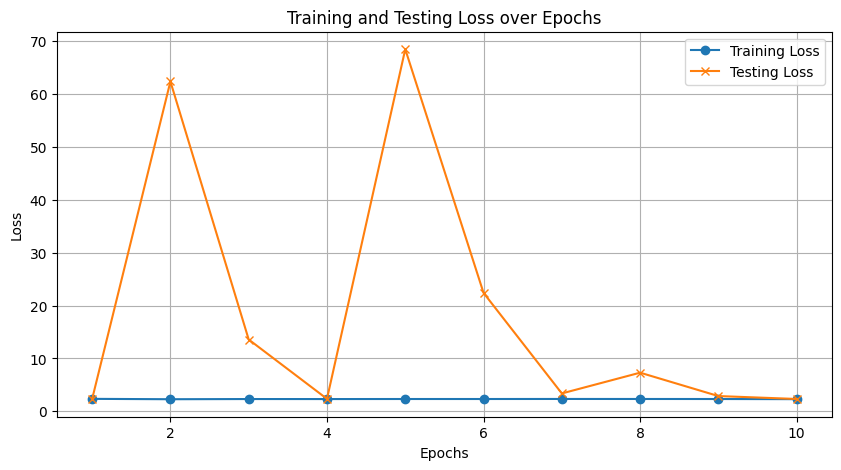

In [41]:
# Training DeepMLP
# your code here


# Save the losses during training and testing and plot them using plot_loss()
# your code here

/tmp/ipykernel_22431/2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1, Train Loss: 3.5400, Train Acc: 14.52%, Test Loss: 5.7835, Test Acc: 19.80%
Epoch 2, Train Loss: 3.0803, Train Acc: 21.48%, Test Loss: 4.3263, Test Acc: 24.60%
Epoch 3, Train Loss: 2.4473, Train Acc: 26.46%, Test Loss: 2.4702, Test Acc: 31.80%
Epoch 4, Train Loss: 2.2729, Train Acc: 30.52%, Test Loss: 2.2675, Test Acc: 31.20%
Epoch 5, Train Loss: 2.1047, Train Acc: 35.30%, Test Loss: 2.2999, Test Acc: 34.80%
Epoch 6, Train Loss: 1.9481, Train Acc: 37.28%, Test Loss: 2.0056, Test Acc: 36.60%
Epoch 7, Train Loss: 1.7600, Train Acc: 40.78%, Test Loss: 1.9843, Test Acc: 36.20%
Epoch 8, Train Loss: 1.7039, Train Acc: 42.70%, Test Loss: 1.7946, Test Acc: 39.40%
Epoch 9, Train Loss: 1.6227, Train Acc: 47.32%, Test Loss: 1.7832, Test Acc: 38.00%
Epoch 10, Train Loss: 1.5462, Train Acc: 50.58%, Test Loss: 2.4930, Test Acc: 36.80%


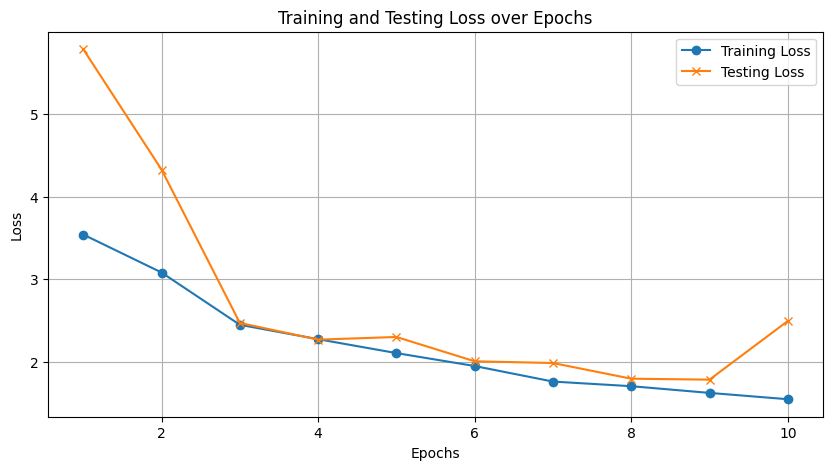

In [40]:
# Training DeepMLP
# your code here


# Save the losses during training and testing and plot them using plot_loss()
# your code here

#### Bonus: Try to see the gradient flow when training the above networks

/tmp/ipykernel_22431/2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/100]
Train Loss: 3.3950, Train Acc: 14.86%
Average Gradient Norm: 27.4979
Epoch [2/100]
Train Loss: 3.0062, Train Acc: 21.44%
Average Gradient Norm: 16.7026
Epoch [3/100]
Train Loss: 2.4888, Train Acc: 25.76%
Average Gradient Norm: 13.3603
Epoch [4/100]
Train Loss: 2.1574, Train Acc: 30.28%
Average Gradient Norm: 10.7063
Epoch [5/100]
Train Loss: 2.0989, Train Acc: 32.36%
Average Gradient Norm: 10.0257
Epoch [6/100]
Train Loss: 1.9071, Train Acc: 36.68%
Average Gradient Norm: 7.2165
Epoch [7/100]
Train Loss: 1.7448, Train Acc: 40.20%
Average Gradient Norm: 6.4097
Epoch [8/100]
Train Loss: 1.7006, Train Acc: 43.34%
Average Gradient Norm: 6.8695
Epoch [9/100]
Train Loss: 1.5611, Train Acc: 46.94%
Average Gradient Norm: 5.6445
Epoch [10/100]
Train Loss: 1.5169, Train Acc: 51.36%
Average Gradient Norm: 5.6886
Epoch [11/100]
Train Loss: 1.4620, Train Acc: 52.28%
Average Gradient Norm: 6.0525
Epoch [12/100]
Train Loss: 1.4051, Train Acc: 54.38%
Average Gradient Norm: 4.5890
Epoch [1